# Understanding unit conversions

In this tutorial we exemplify how unit conversions play a role in the underlying QoolQit program compilation and execution. We will analyze the dynamics of one of the most fundamental algorithmic behaviors in the Rydberg analog model: the **Rydberg blockade**.


## Rydberg blockade

Consider a system of two qubits in state $|00\rangle$, placed in two sites at a distance $r$ at $t=0$. For simplicity, we set the program drive as a constant amplitude waveform of value $\Omega$ for $t\geq0$. Following the <a href="https://pasqal-io.github.io/qoolqit/latest/theory/rydberg_model/"> Rydberg model page </a>, the two-qubit system evolves with the Hamiltonian

$$
H_{01}=\frac{\Omega}{2}(\hat{\sigma}^x_0+\hat{\sigma}^x_1)+\frac{1}{r^6}\hat{n}_0\hat{n}_1
$$

The interaction term imposes an energy of $1/r^6$ on state $|11\rangle$, and thus this state is only accessible if $\Omega>1/r^6$. As such, the radius

$$
r_b=\Omega^{-\frac{1}{6}}
$$

is called the **Rydberg blockade radius**, such that if two qubits are at a distance $r < r_b$, the state $|11\rangle$ is blocked, while if they are at a distance $r > r_b$, the state $|11\rangle$ is accessible.

For simplicity, we we now set $\Omega = 1$, and thus $r_b = 1$. If you solve the system analytically you will find that in the blockade regime the initial population of $|00\rangle$ transitions to $\frac{1}{\sqrt{2}}|01\rangle+|10\rangle$ at $t=\pi/\sqrt{2}$, while in the non-blockade regime the transition $|00\rangle \rightarrow |11\rangle$ is complete at $t=\pi$.


Let's now write a simple program in **QoolQit** to demonstrate the behavior described. We will create a program for the $r < 1$ regime (qubits are close), and one for the $r > 1$ (qubits are far), and start by defining the drive of the program with two different durations.


In [18]:
import numpy as np

from qoolqit import Constant, Drive

omega = 1.0

# Defining the Drive for the close / far system
duration_close = np.pi * np.sqrt(2.0)
duration_far = np.pi

drive_close = Drive(amplitude=Constant(duration_close, omega))
drive_far = Drive(amplitude=Constant(duration_far, omega))


Now we create the two registers, and then instantiate the programs. We arbitrarily pick $r_\text{close} = 0.7$ and $r_\text{far} = 1.5$.


In [19]:
from qoolqit import QuantumProgram, Register

r_close = 0.7
r_far = 1.5

reg_close = Register.from_coordinates([(0.0, 0.0), (r_close, 0.0)])
reg_far = Register.from_coordinates([(0.0, 0.0), (r_far, 0.0)])

program_close = QuantumProgram(reg_close, drive_close)
program_far = QuantumProgram(reg_far, drive_far)

## Running on a mock device

First, let's run the programs on a mock device and see what we get. We instantiate the device, compile both programs, and call the `run()` method.

In [20]:
from qoolqit import MockDevice

device = MockDevice()

program_close.compile_to(device)
program_far.compile_to(device)

For executing the programs, we will do a statevector simulation of the dynamics and save 100 states during the duration of the program.

In [21]:
from pulser.backend import EmulationConfig, StateResult

from qoolqit.execution import LocalEmulator

evaluation_times = np.linspace(0.0, 1.0, 100).tolist()
observables = (StateResult(evaluation_times=evaluation_times),)
emulation_config = EmulationConfig(observables=observables)
emulator = LocalEmulator(emulation_config=emulation_config)

results_close = emulator.run(program_close)
results_far = emulator.run(program_far)

# states in the qutip backend are qutip objects
states_close = [np.flip(state.to_qobj().full().flatten()) for state in results_close[0].state]
states_far = [np.flip(state.to_qobj().full().flatten()) for state in results_far[0].state]


With the states saved, we can plot the results. We do this by defining a plotting function so that we can reuse it later.


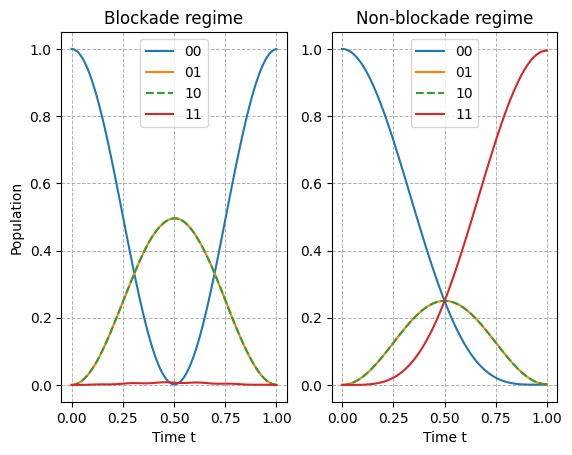

In [22]:
import matplotlib.pyplot as plt


def get_figure(states_close: list[np.ndarray], states_far: list[np.ndarray], t_vals) -> plt.Figure:
    # Compute populations
    pop_close = abs(np.stack(states_close).T) ** 2
    pop_far = abs(np.stack(states_far).T) ** 2

    fig, ax = plt.subplots(1, 2)

    ax[0].grid(True, linestyle="--", linewidth=0.7)
    ax[0].plot(t_vals, pop_close[0], label="00")
    ax[0].plot(t_vals, pop_close[1], label="01")
    ax[0].plot(t_vals, pop_close[2], label="10", linestyle="dashed")
    ax[0].plot(t_vals, pop_close[3], label="11")
    ax[0].set_ylabel("Population")
    ax[0].set_xlabel("Time t")
    ax[0].set_title("Blockade regime")
    ax[0].legend()

    ax[1].grid(True, linestyle="--", linewidth=0.7)
    ax[1].plot(t_vals, pop_far[0], label="00")
    ax[1].plot(t_vals, pop_far[1], label="01")
    ax[1].plot(t_vals, pop_far[2], label="10", linestyle="dashed")
    ax[1].plot(t_vals, pop_far[3], label="11")
    ax[1].set_xlabel("Time t")
    ax[1].set_title("Non-blockade regime")
    ax[1].legend()

    return fig


fig = get_figure(states_close, states_far, evaluation_times)
plt.show()


As you can see above, the results obtained are exactly what we expected from the model. Now we may check what was the Pulser sequence that was used under the hood, for example, for the blockaded regime.


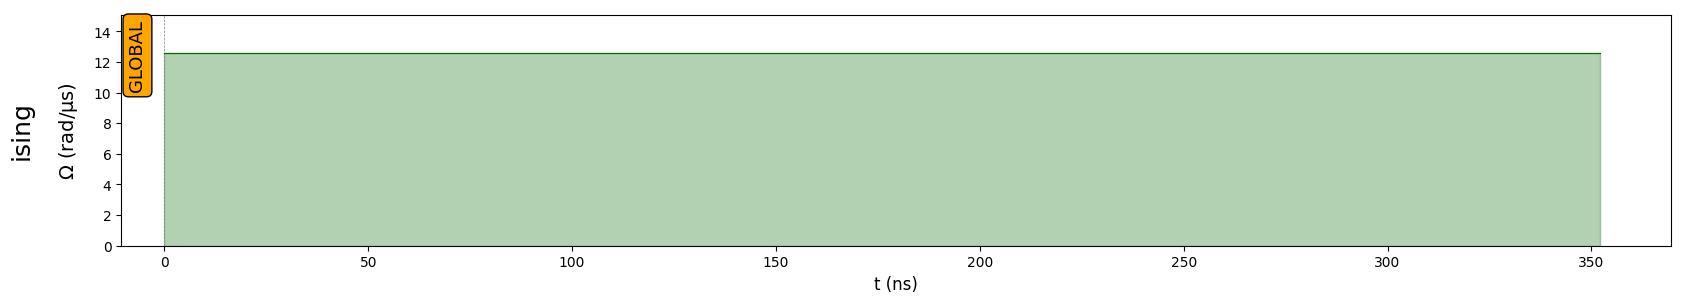

In [23]:
program_close.draw(compiled = True)


This was the sequence created by the device's default unit converter.


In [24]:
print("Converter:", device.converter)

Converter: UnitConverter(time = 79.577, energy = 12.566, distance = 8.692)


As described in the model page, unit conversion is done by multiplying the values in QoolQit by the conversion factors. You can double-check yourself that the values of $\Omega$ and duration for this sequence match the ones set in QoolQit multiplied by the factors in the converter.

What if we wanted to set some custom conversion factors? Would it make a difference? Below we set the energy unit to $10.0$, and check that the converter is updated.

In [25]:
device.set_energy_unit(10.0)
print("Updated converter:", device.converter)

Updated converter: UnitConverter(time = 100.000, energy = 10.000, distance = 9.030)


We can now recompile our programs to the updated device, run, and plot the results.

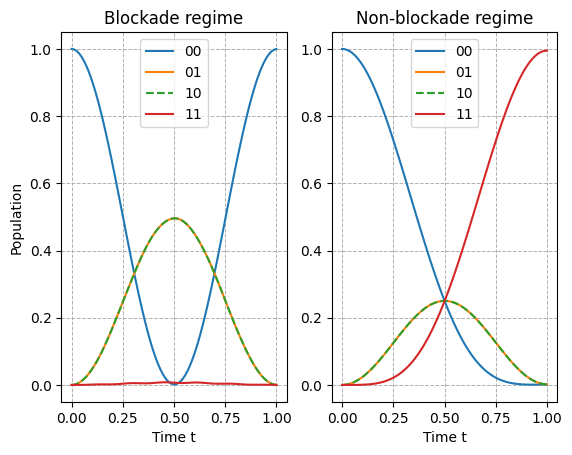

In [26]:
program_close.compile_to(device)
program_far.compile_to(device)

results_close = emulator.run(program_close)
results_far = emulator.run(program_far)

# states in the qutip backend are qutip objects
states_close = [np.flip(state.to_qobj().full().flatten()) for state in results_close[0].state]
states_far = [np.flip(state.to_qobj().full().flatten()) for state in results_far[0].state]

fig = get_figure(states_close, states_far, evaluation_times)
plt.show()

As expected, the results are exactly the same. Our program did not change, and since we are running on a perfect device the conversion is exact, independently of the conversion factors used. Only the **physical implementation** of our program has changed.


## Running on a realistic device

Now, let's replicate this experiment for a more realistic device. Note that the workflow we will show now is for demonstration purposes, and is not the recommended one for the average QoolQit user.

We can use the `AnalogDevice`, which unlike the `MockDevice`, has limitations on certain values that can be set. This is immediately clear if we try to compile the program as it is to the default settings of the `AnalogDevice`:


In [27]:
from qoolqit import AnalogDevice

device = AnalogDevice()

try:
    program_close.compile_to(device)
except Exception as error:
    print("Compilation (close) failed:", error)

program_far.compile_to(device)
print("Far program compiled.")


Compilation (close) failed: Failed to compile the sequence due to:

The minimal distance between atoms in this device (5 µm) is not respected (up to a precision of 1e-6 µm) for the pairs: [('0', '1')]
Far program compiled.


While the program setting the qubits far apart compiled without problems, the one with the qubits closer together did not, because the compiler tried to put atoms closer than the minimum physical distance allowed on this device. Such limitations can be checked at the level of QoolQit in the `specs` property of the devices:


In [28]:
print("Device specs:", device.specs)

Device specs: {'max_duration': 75.39822368615503, 'max_amplitude': 1.0, 'max_detuning': 10.0, 'min_distance': 0.7809234915702248}


Note that the values shown are **adimensional**, meaning that they depend on the current unit converter that is set on the device. Since we tried setting the qubits at $r_\text{close} = 0.7$, this is lower than the minimum distance allowed on this device given the default converter.

Changing the program would be an option to achieve the compilation. For example, instead of using $\Omega = 1$, we could set $\Omega = 0.3$, which in turn would increase the blockade radius. Then we could set $r_\text{close} = 0.7r_b\approx0.856$ and $r_\text{far} = 1.5r_b\approx1.833$, which would now match the device constraints, and we would observe the same blockade behavior (albeit with the dynamics on a different time-scale, scaled as $t/\Omega$).

However, that would be a fundamentally different program, and the goal in this tutorial is to exemplify how a fixed program can be translated differently through unit conversions. So, instead, we are just going to compile our original program differently. Below we check the unit converter used, then make a small arbitrary increase to the distance unit, and check the updated converter.


In [29]:
print("Converter (before):", device.converter)
device.set_distance_unit(7.5)
print("Converter (after):", device.converter)

Converter (before): UnitConverter(time = 79.577, energy = 12.566, distance = 6.403)
Converter (after): UnitConverter(time = 205.584, energy = 4.864, distance = 7.500)



Let's check the device specs again:


In [30]:
print("Device specs (updated):", device.specs)

Device specs (updated): {'max_duration': 29.185197447901235, 'max_amplitude': 2.583440589043439, 'max_detuning': 25.83440589043439, 'min_distance': 0.6666666666666666}



With the updated converter the allowed minimum distance is smaller, and both programs should now compile. We can again plot the results:


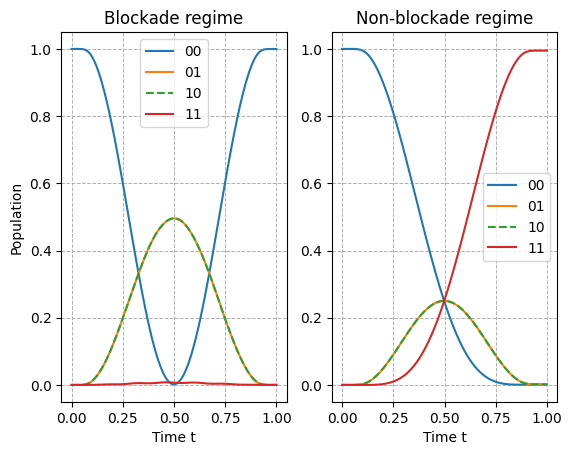

In [31]:
program_close.compile_to(device)
program_far.compile_to(device)

emulation_config = EmulationConfig(observables=observables, with_modulation=True)
emulator = LocalEmulator(emulation_config=emulation_config)

results_close = emulator.run(program_close)
results_far = emulator.run(program_far)

# states in the qutip backend are qutip objects
states_close = [np.flip(state.to_qobj().full().flatten()) for state in results_close[0].state]
states_far = [np.flip(state.to_qobj().full().flatten()) for state in results_far[0].state]

fig = get_figure(states_close, states_far, evaluation_times)


Once again, we get the expected results. However, notice that there is slight difference in the dynamics compared to the ideal case shown earlier, as both the start and end of the plots are more horizontal. Let's inspect the compiled sequence for one of the programs.


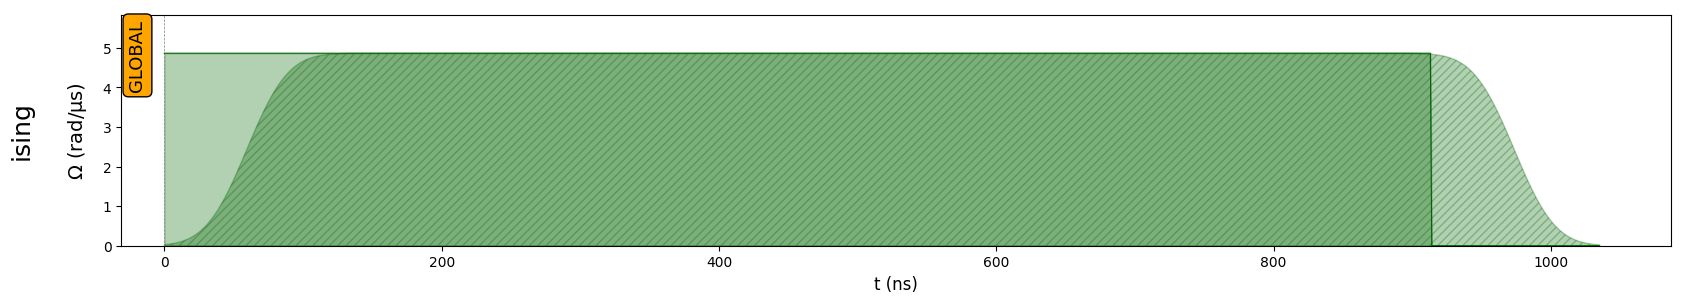

In [32]:
program_close.draw(compiled = True)

As you can see, in a realistic device you cannot implement a perfectly square waveform, as the system requires some time to raise and lower the amplitude of the laser that implements it. This is called the waveform modulation and in this case it introduces a discrepancy between the expected results in the ideal scenario and the actual results from the physical implementation.



## Using compiler profiles

At the start of the previous section it was noted that the workflow of manually changing the unit converter is not necessarily the recommended one, and should be reserved for more advanced users. At the same time, at the end of the section we saw that in this case the compilation was not ideal, because the program was slightly affected by waveform modulation errors.

To address both of these issues, we can use **compiler profiles**. These are directives for the compiler to follow while trying to compile the sequence, which can be designed with various specific purposes in mind. Going in detail on compiler profiles in QoolQit is not the purpose of this tutorial, but here we can exemplify the usage of one:


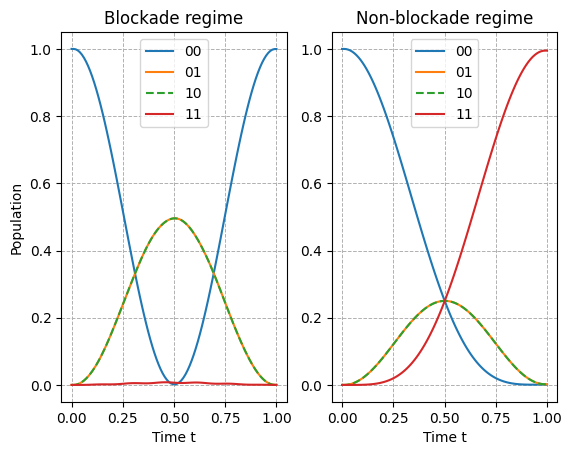

In [33]:
from qoolqit import AnalogDevice, CompilerProfile

device = AnalogDevice()

program_close.compile_to(device, profile=CompilerProfile.MAX_DURATION)
program_far.compile_to(device, profile=CompilerProfile.MAX_DURATION)

results_close = emulator.run(program_close)
results_far = emulator.run(program_far)

# states in the qutip backend are qutip objects
states_close = [np.flip(state.to_qobj().full().flatten()) for state in results_close[0].state]
states_far = [np.flip(state.to_qobj().full().flatten()) for state in results_far[0].state]

fig = get_figure(states_close, states_far, evaluation_times)


The results are now much closer to the ideal case. Let's inspect the compiled sequence:


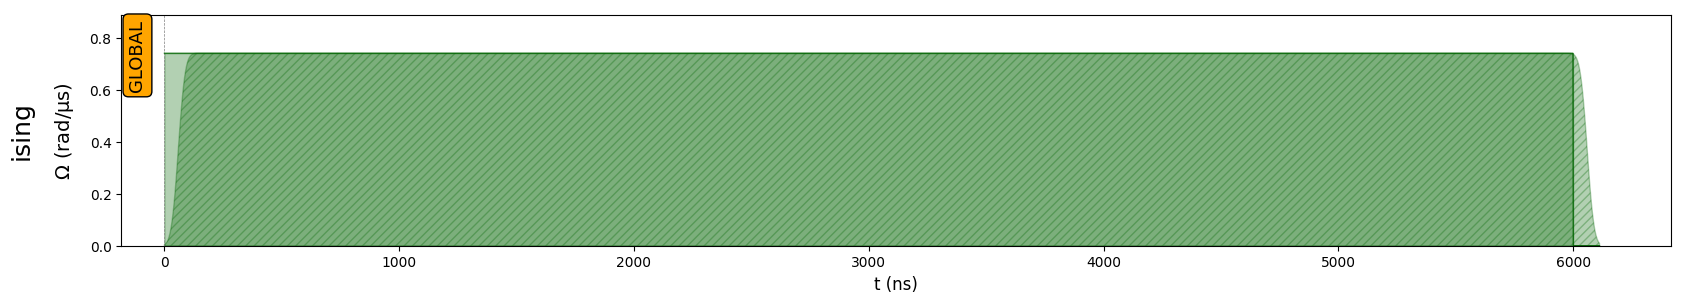

In [34]:
program_close.draw(compiled = True)


By using the `CompilerProfile.MAX_DURATION`, the compiler automatically mapped whatever was the program duration to be equal to the device's maximum duration. This was done by calculating the ideal conversions factors that match this condition, and using those. This not only allowed for a successful compilation of both programs, but it also mitigated the modulation errors by stretching the program over a longer time.

> **Note:** In the future we can add a `safe_mode = True` to the compiler, where a profile is dynamically adjusted until it achieves a successful compilation.
